In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# DATA

In [3]:
df = pd.read_csv('insurance_prediction.csv')

In [4]:
df.dtypes

id                       int64
Gender                  object
Age                      int64
Driving_License          int64
Region_Code              int64
Previously_Insured       int64
Vehicle_Age             object
Vehicle_Damage          object
Annual_Premium           int64
Policy_Sales_Channel     int64
Vintage                  int64
Response                 int64
dtype: object

# DATA Preparation

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df['vehicle_age'] = df['vehicle_age'].str.replace('> 2 Years', 'more than 2 Years')

df['vehicle_age'] = df['vehicle_age'].str.replace('< 1 Year', 'less than 1 Year')

df['previously_insured'] = df['previously_insured'].map({0:'no', 1:'yes'}) 

df['driving_license'] = df['driving_license'].map({0:'no', 1:'yes'})

In [7]:
categorical_list = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_list:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [8]:
categorical = ['gender', 
               'driving_license', 
               'previously_insured', 
               'vehicle_age', 
               'vehicle_damage']

numerical = ['age', 
             'region_code',
             'annual_premium',
             'policy_sales_channel', 
             'vintage']

features = numerical + categorical
target= ['response']

In [9]:
df.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

# Setting up the validation framework

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
rs=1

In [12]:
df_full_train, df_test = train_test_split(df[features+target], test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

In [13]:
len(df_train), len(df_val), len(df_test)

(228665, 76222, 76222)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.response.values
y_val = df_val.response.values
y_test = df_test.response.values

del df_train['response']
del df_val['response']
del df_test['response']

# EDA

In [16]:
df_full_train = df_full_train.reset_index(drop=True)

In [17]:
df_full_train.response.value_counts(normalize=True)

0    0.876872
1    0.123128
Name: response, dtype: float64

In [18]:
df_full_train[numerical].describe().round(2)

,age,region_code,annual_premium,policy_sales_channel,vintage
count,304887.00,304887.00,304887.00,304887.00,304887.00
mean,38.84,26.39,30583.35,112.01,154.33
std,15.52,13.23,17266.95,54.22,83.65
min,20.00,0.00,2630.00,1.00,10.00
25%,25.00,15.00,24419.00,27.50,82.00
50%,36.00,28.00,31681.00,133.00,154.00
75%,49.00,35.00,39399.50,152.00,227.00
max,85.00,52.00,540165.00,163.00,299.00


In [19]:
df_full_train[categorical].describe(include=["O"])

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage
count,304887,304887,304887,304887,304887
unique,2,2,2,3,2
top,male,yes,no,1-2_year,yes
freq,165019,304244,165319,160316,154248


# One-Hot Encoding

In [20]:
from sklearn.feature_extraction import DictVectorizer

In [21]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Metrics

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Results DataFrame

In [23]:
results = []
columns = ['Model', 'RMSE', 'AUC']
df_results = pd.DataFrame(results, columns=columns)

# Models

## 1. logistic Regression

* **Training model and Evaluating the model**

In [24]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression(solver='lbfgs', C=1.0, random_state=rs)
lr.fit(X_train, y_train)

y_pred = lr.predict_proba(X_val)[:,1]

model = 'Logistic_Regression'
rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
auc = (roc_auc_score(y_val, y_pred)).round(4)

results.append((model, rmse, auc))


In [27]:
model, rmse, auc

('Logistic_Regression', 0.3273, 0.5944)

In [28]:
df_results = pd.DataFrame(results, columns=columns)
df_results

,Model,RMSE,AUC
0,Logistic_Regression,0.3273,0.5944


* **Feature Elimination**

In [29]:
orig_score = auc
auc_result=[]

for c in features:
    subset = features.copy()
    subset.remove(c)
    
    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    lr = LogisticRegression(solver='lbfgs', C=1.0, random_state=rs)
    lr.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = lr.predict(X_val)

    score = (roc_auc_score(y_val, y_pred)).round(4)
    diff = (orig_score - score).round(4)
    auc_result.append((c, orig_score, score, diff ))
    

In [33]:
auc_columns = ['Eliminated_Feature', 'AUC', 'AUC_Elimination', 'Diff']
df_auc_results = pd.DataFrame(auc_result, columns=auc_columns)
df_auc_results=df_auc_results.sort_values(by='Diff', ascending=False).reset_index(drop=True)
df_auc_results

,Eliminated_Feature,AUC,AUC_Elimination,Diff
0,region_code,0.5944,0.5000,0.0944
1,gender,0.5944,0.5000,0.0944
2,driving_license,0.5944,0.5000,0.0944
3,previously_insured,0.5944,0.5000,0.0944
4,vehicle_age,0.5944,0.5000,0.0944
5,vehicle_damage,0.5944,0.5000,0.0944
6,annual_premium,0.5944,0.5001,0.0943
7,policy_sales_channel,0.5944,0.5048,0.0896
8,vintage,0.5944,0.5085,0.0859
9,age,0.5944,0.5161,0.0783


## 2.Ridge Regression

In [34]:
from sklearn.linear_model import Ridge

In [35]:
for a in [0, 0.01, 0.1, 1, 10]:
    rg = Ridge(alpha=a,random_state=rs)
    rg.fit(X_train, y_train)
    
    y_pred = rg.predict(X_val)
    
    rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
    auc = (roc_auc_score(y_val, y_pred)).round(4)

    
    print('alpha=%s   %0.4f    %0.4f '% (a, rmse, auc))

alpha=0   5.8100    0.4852 
alpha=0.01   0.3056    0.8186 
alpha=0.1   0.3056    0.8186 
alpha=1   0.3056    0.8186 
alpha=10   0.3056    0.8186 


* ***alpha* equals to 0.01**

In [37]:
rg = Ridge(alpha=0.01,random_state=rs)
rg.fit(X_train, y_train)

y_pred = rg.predict(X_val)

model = 'Ridge_Regression'
rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
auc = (roc_auc_score(y_val, y_pred)).round(4)

results.append((model, rmse, auc))

In [38]:
model, rmse, auc

('Ridge_Regression', 0.3056, 0.8186)

In [39]:
df_results = pd.DataFrame(results, columns=columns)
df_results

,Model,RMSE,AUC
0,Logistic_Regression,0.3273,0.5944
1,Ridge_Regression,0.3056,0.8186


## 3.Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [42]:
depths = [1, 2, 3, 4, 5, 8, 10, 12, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth, random_state=rs)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:,1]

    rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
    auc = (roc_auc_score(y_val, y_pred)).round(4)
    
    print('%4s -> %.4f   %.4f'% (depth, rmse, auc))

   1 -> 0.3089   0.7580
   2 -> 0.3049   0.7971
   3 -> 0.3029   0.8143
   4 -> 0.3026   0.8187
   5 -> 0.3020   0.8238
   8 -> 0.3005   0.8349
  10 -> 0.3011   0.8354
  12 -> 0.3036   0.8311
  15 -> 0.3125   0.8084
  20 -> 0.3415   0.7572
None -> 0.4246   0.5983


* **The best results are** 
    * **maxdepth = 8  -> 0.3005   0.8349**
    * **maxdepth = 10 -> 0.3011   0.8354**

In [43]:
scores = []

for depth in [8,10]:
    for s in [1, 5, 10, 15, 20, 50, 80, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=rs)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]

        rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
        auc = (roc_auc_score(y_val, y_pred)).round(4)
        
        scores.append((depth, s, rmse, auc))

In [44]:
dt_columns = ['max_depth', 'min_samples_leaf', 'rmse', 'auc']
df_scores = pd.DataFrame(scores, columns=dt_columns)

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

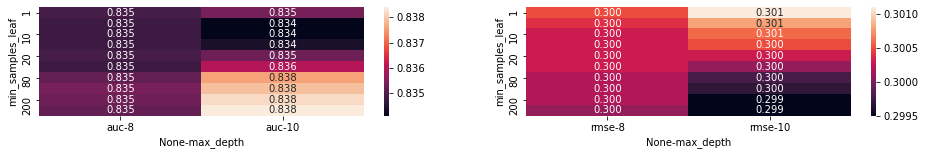

In [45]:
plt.figure(figsize=(16, 2))

plt.subplot(1,2,1)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

plt.subplot(1,2,2)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

* **maxdepth=10, min_samples_leaf=80**

In [46]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=80, random_state=rs)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:,1]

model='Decision Tree'
rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
auc = (roc_auc_score(y_val, y_pred)).round(4)

results.append((model, rmse, auc))

In [47]:
model, rmse, auc

('Decision Tree', 0.2998, 0.8376)

In [48]:
df_results = pd.DataFrame(results, columns=columns)
df_results

,Model,RMSE,AUC
0,Logistic_Regression,0.3273,0.5944
1,Ridge_Regression,0.3056,0.8186
2,Decision Tree,0.2998,0.8376


In [49]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- previously_insured=yes <= 0.50
|   |--- age <= 27.50
|   |   |--- policy_sales_channel <= 150.50
|   |   |   |--- policy_sales_channel <= 123.00
|   |   |   |   |--- gender=male <= 0.50
|   |   |   |   |   |--- region_code <= 10.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- region_code >  10.50
|   |   |   |   |   |   |--- region_code <= 35.50
|   |   |   |   |   |   |   |--- region_code <= 27.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- region_code >  27.50
|   |   |   |   |   |   |   |   |--- vehicle_age=1-2_year <= 0.50
|   |   |   |   |   |   |   |   |   |--- age <= 24.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age >  24.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- vehicle_age=1-2_year >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- region_code >  35.50
|   |   |   |   |   |   |  

## 4.Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=rs)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]

    rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
    auc = (roc_auc_score(y_val, y_pred)).round(4)
    
    scores.append((n, rmse, auc))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse', 'auc'])

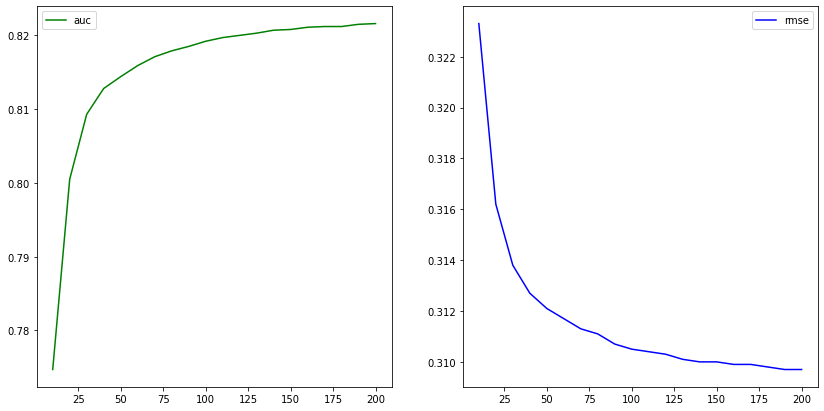

In [53]:
plt.figure(figsize=(14, 7))


plt.subplot(1,2,1)
plt.plot(df_scores.n_estimators, df_scores.auc, 'g', label='auc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(df_scores.n_estimators, df_scores.rmse, 'b', label='rmse')
plt.legend()

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=rs,
                                    warm_start=True)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:,1]

        rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
        auc = (roc_auc_score(y_val, y_pred)).round(4)

        scores.append((d, n, rmse, auc))

In [55]:
rf_columns = ['max_depth', 'n_estimators', 'rmse', 'auc']
df_scores = pd.DataFrame(scores, columns=rf_columns)

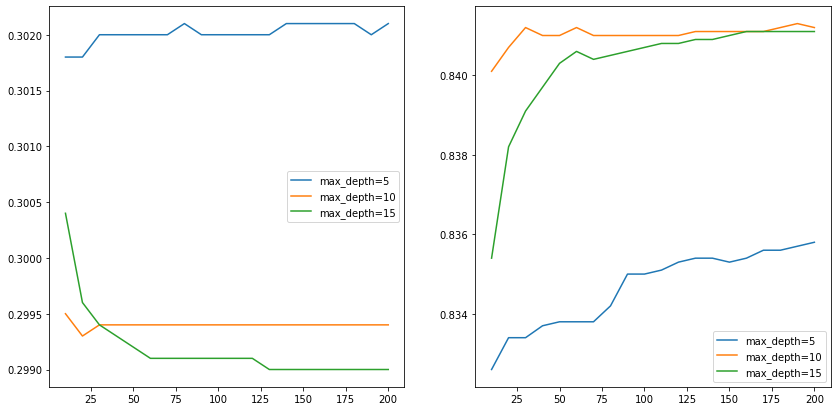

In [56]:
plt.figure(figsize=(14, 7))


plt.subplot(1,2,1)
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

plt.subplot(1,2,2)
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

* **max_depth=15**

In [58]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=15,
                                    min_samples_leaf=s,
                                    random_state=rs,
                                    warm_start=True)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]

        rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
        auc = (roc_auc_score(y_val, y_pred)).round(4)

        scores.append((s, n, rmse, auc))

In [59]:
rf_columns = ['min_samples_leaf', 'n_estimators', 'rmse', 'auc']
df_scores = pd.DataFrame(scores, columns=rf_columns)

In [60]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

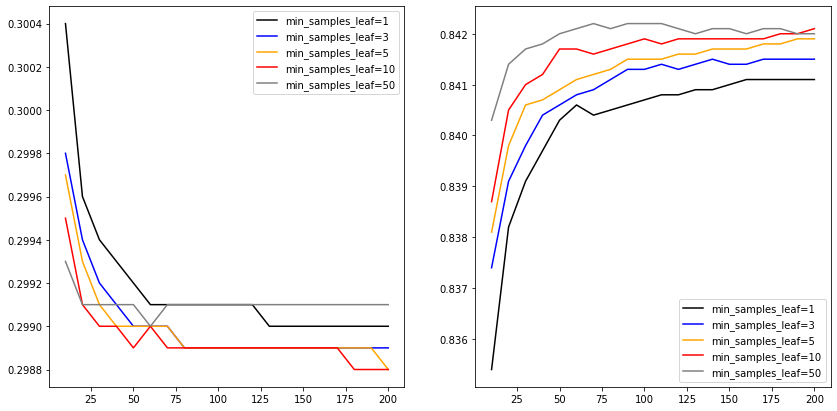

In [61]:
plt.figure(figsize=(14, 7))


plt.subplot(1,2,1)
for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

plt.subplot(1,2,2)
for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

* **min_sample_leaf=10**

In [62]:
rf = RandomForestClassifier(n_estimators=200,
                                    max_depth=15,
                                    min_samples_leaf=10,
                                    random_state=rs,
                                    warm_start=True)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:,1]

model='Random_Forest'
rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
auc = (roc_auc_score(y_val, y_pred)).round(4)

results.append((model, rmse, auc))

In [63]:
model, rmse, auc

('Random_Forest', 0.2988, 0.8421)

In [64]:
df_results = pd.DataFrame(results, columns=columns)
df_results

,Model,RMSE,AUC
0,Logistic_Regression,0.3273,0.5944
1,Ridge_Regression,0.3056,0.8186
2,Decision Tree,0.2998,0.8376
3,Random_Forest,0.2988,0.8421


## 5.XGBoost

In [65]:
import xgboost as xgb

In [66]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.get_feature_names())

In [67]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [68]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [69]:
scores = {}

In [70]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [71]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.5'

In [72]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [73]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [74]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [75]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

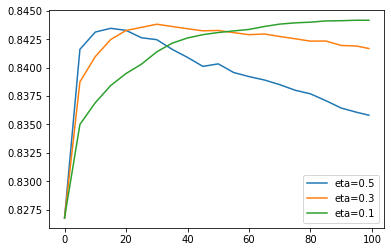

In [76]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

#plt.ylim(0.8, 0.84)
plt.legend()

* **eta=0.1**

In [77]:
scores = {}

In [78]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [79]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [80]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [81]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

In [82]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [83]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

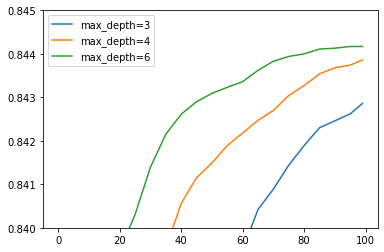

In [86]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.840, 0.845)
plt.legend()

* **max_depth=6**

In [87]:
scores = {}

In [88]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [89]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [90]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [91]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [92]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [93]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

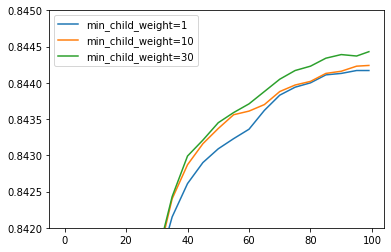

In [95]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.842, 0.845)
plt.legend()

* **min_child_weight: 30**

In [108]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

xgbmodel = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

[0]	train-auc:0.82970	val-auc:0.82691
[5]	train-auc:0.83806	val-auc:0.83513
[10]	train-auc:0.84053	val-auc:0.83755
[15]	train-auc:0.84147	val-auc:0.83843
[20]	train-auc:0.84232	val-auc:0.83950
[25]	train-auc:0.84342	val-auc:0.84064
[30]	train-auc:0.84465	val-auc:0.84158
[35]	train-auc:0.84572	val-auc:0.84243
[40]	train-auc:0.84655	val-auc:0.84299
[45]	train-auc:0.84705	val-auc:0.84321
[50]	train-auc:0.84754	val-auc:0.84345
[55]	train-auc:0.84795	val-auc:0.84359
[60]	train-auc:0.84831	val-auc:0.84371
[65]	train-auc:0.84881	val-auc:0.84388
[70]	train-auc:0.84924	val-auc:0.84405
[75]	train-auc:0.84968	val-auc:0.84417
[80]	train-auc:0.84993	val-auc:0.84423
[85]	train-auc:0.85048	val-auc:0.84434
[90]	train-auc:0.85109	val-auc:0.84439
[95]	train-auc:0.85146	val-auc:0.84437
[99]	train-auc:0.85194	val-auc:0.84443


In [97]:
y_pred = xgbmodel.predict(dval)

model='XGBoost'
rmse = (np.sqrt(mean_squared_error(y_val, y_pred))).round(4)
auc = (roc_auc_score(y_val, y_pred)).round(4)

results.append((model, rmse, auc))

In [98]:
model, rmse, auc

('XGBoost', 0.2982, 0.8445)

In [99]:
df_results = pd.DataFrame(results, columns=columns)
df_results

,Model,RMSE,AUC
0,Logistic_Regression,0.3273,0.5944
1,Ridge_Regression,0.3056,0.8186
2,Decision Tree,0.2998,0.8376
3,Random_Forest,0.2988,0.8421
4,XGBoost,0.2982,0.8445


# Finding y_pred Threshold

In [109]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [110]:
y_pred = xgbmodel.predict(dval)
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [111]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

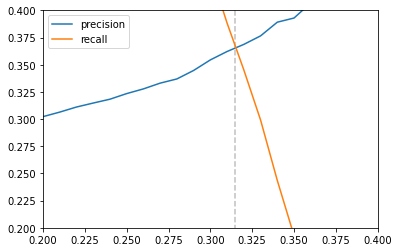

In [115]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.ylim(0.2,0.4)
plt.xlim(0.2,0.4)
plt.vlines(0.315, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

* **t=0.315**

# Train the BEST MODEL: XGBOOST

In [100]:
df_full_train

,age,region_code,annual_premium,policy_sales_channel,vintage,gender,driving_license,previously_insured,vehicle_age,vehicle_damage,response
0,22,24,2630,152,68,female,yes,yes,less_than_1_year,no,0
1,22,46,29544,152,202,male,yes,yes,less_than_1_year,no,0
2,61,50,34217,124,122,female,yes,no,1-2_year,yes,0
3,29,32,33889,152,131,female,yes,yes,less_than_1_year,yes,0
4,23,25,21758,152,144,male,yes,no,less_than_1_year,yes,0
...,...,...,...,...,...,...,...,...,...,...,...
304882,27,11,26584,152,295,female,yes,yes,less_than_1_year,no,0
304883,39,41,27136,156,233,female,yes,no,1-2_year,yes,0
304884,45,28,33735,124,120,male,yes,yes,1-2_year,no,0
304885,43,36,35142,152,108,female,yes,yes,1-2_year,no,0


In [101]:
y_full_train = df_full_train.response.values

In [102]:
del df_full_train['response']

In [103]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [104]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [116]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1,
}

xgbmodel = xgb.train(xgb_params, dfulltrain, num_boost_round=100)

In [106]:
y_pred = xgbmodel.predict(dtest)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred))).round(4)
auc = (roc_auc_score(y_test, y_pred)).round(4)

print('auc=', auc)
print('rmse=', rmse)

auc= 0.8599
rmse= 0.2918


# Test the Model 

In [117]:
customer = {"gender": "male",
            "age": 21,
            "driving_license": "yes",
            "region_code": 30,
            "previously_insured": "yes",
            "vehicle_age": "less_than_1_year",
            "vehicle_damage": "yes",
            "annual_premium": 21425,
            "policy_sales_channel": 26,
            "vintage": 252
            }

In [118]:
X = dv.transform([customer])

In [119]:
dtest = xgb.DMatrix(X, feature_names=dv.get_feature_names())

In [120]:
y_pred = xgbmodel.predict(dtest)
if y_pred > 0.3:
    print('Customer is interested in Vehicle Insurance provided by the company')
else:
    print('Customer is NOT interested in Vehicle Insurance provided by the company')

Customer is NOT interested in Vehicle Insurance provided by the company
